---
title: PLM
subtitle: Análisis de datos
author: Jefe confiabilidad
date: 2025-03-21
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path

# # Define the path you want to add
# new_path = "/home/cecilvega/PycharmProjects/kverse"  # Path("C:\\Users\\andmn\\PycharmProjects\\kverse")
#
# # Convert Path object to string and append it to sys.path
# sys.path.append(str(new_path))

import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources.dplyr import *
from kdags.resources.tidyr import *
from io import BytesIO
import pdfplumber

# from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import *
import numpy as np

context = dg.build_asset_context()

from kdags.resources.ggplot import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Data Haulcycle

Disponible en:

https://globalkomatsu.sharepoint.com/sites/KCHCLSP00022/Shared%20Documents/01.%20%C3%81REAS%20KCH/1.6%20CONFIABILIDAD/CAEX/ANTECEDENTES/OPERATION/PLM/haul.csv

In [2]:
haul_df = Readr.Operation.read_haul(context)

In [ ]:
df = haul_df.clone()


df = df.with_columns(
    pl.col("peak_sprung_load")
    .rolling_mean_by(by="record_dt", window_size="120d")
    .alias("rolling_fleet_peak_sprung_load")
)
df = df.with_columns(
    pl.col("peak_sprung_load")
    .rolling_mean_by(by="record_dt", window_size="120d")
    .over("equipment_name")
    .alias("rolling_peak_sprung_load")
)
df

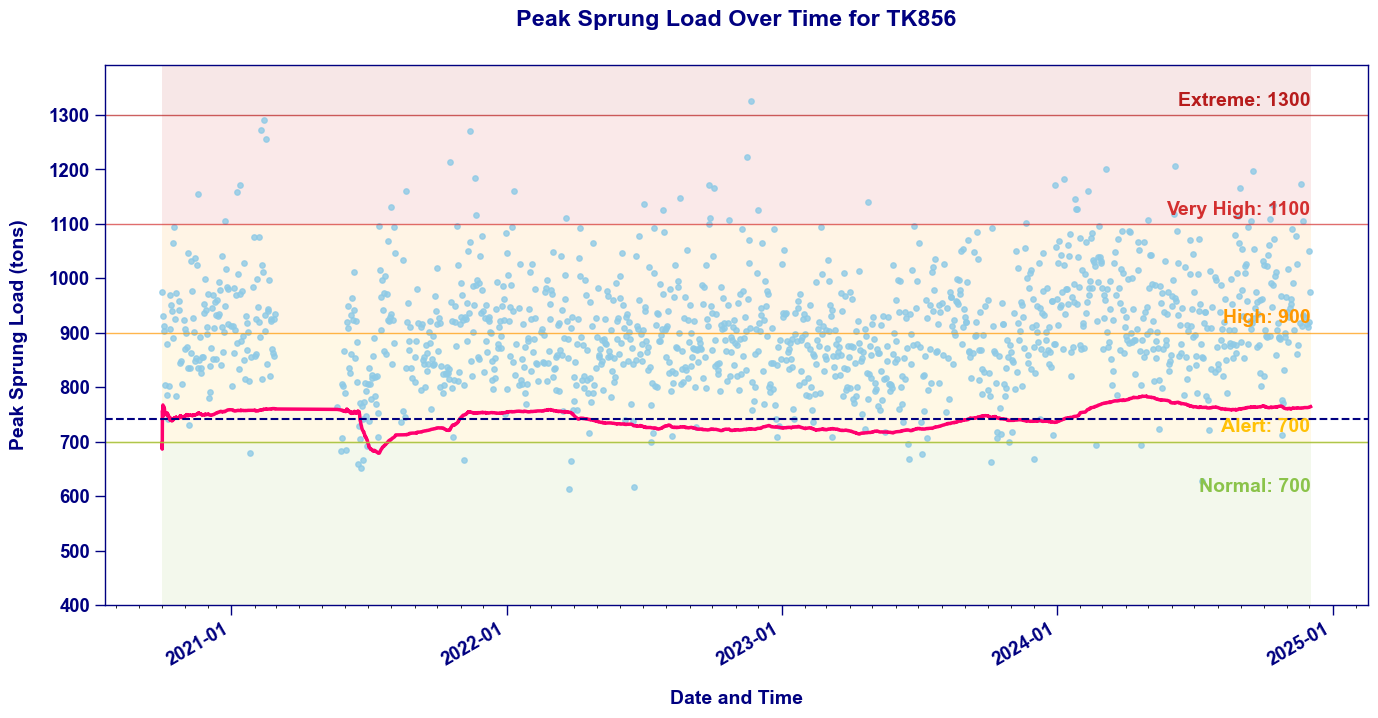

In [17]:
window_size = 30
figsize = (14, 8)
from matplotlib.patches import Rectangle

equipment_name = "TK856"
pandas_df = df.to_pandas()
# Filter for the specific equipment
equipment_df = df.filter(pl.col("equipment_name") == equipment_name)

# Convert to pandas and sort by datetime for proper plotting
filtered_df = equipment_df.to_pandas().sort_values("record_dt")

# Define the thresholds based on Image 2
thresholds = [
    {"level": "Normal", "max": 700, "color": "#8BC34A", "alpha": 0.1},  # Green
    {
        "level": "Alert",
        "min": 700,
        "max": 900,
        "color": "#FFC107",
        "alpha": 0.1,
    },  # Yellow
    {
        "level": "High",
        "min": 900,
        "max": 1100,
        "color": "#FF9800",
        "alpha": 0.1,
    },  # Orange
    {
        "level": "Very High",
        "min": 1100,
        "max": 1300,
        "color": "#D32F2F",
        "alpha": 0.1,
    },  # Dark Red
    {"level": "Extreme", "min": 1300, "color": "#B71C1C", "alpha": 0.1},  # Red
]

# Create theme and figure
theme = GGPrism()
fig, ax = theme.create_figure(figsize=figsize)

# Add threshold background regions
y_min = 400
y_max = max(1350, filtered_df["peak_sprung_load"].max() * 1.05)

# Draw the threshold background regions
for threshold in thresholds:
    if "min" not in threshold and "max" in threshold:
        # Normal range (below first threshold)
        rect = Rectangle(
            (filtered_df["record_dt"].min(), y_min),
            filtered_df["record_dt"].max() - filtered_df["record_dt"].min(),
            threshold["max"] - y_min,
            color=threshold["color"],
            alpha=threshold["alpha"],
            linewidth=0,
        )
        ax.add_patch(rect)
    elif "min" in threshold and "max" in threshold:
        # Middle ranges
        rect = Rectangle(
            (filtered_df["record_dt"].min(), threshold["min"]),
            filtered_df["record_dt"].max() - filtered_df["record_dt"].min(),
            threshold["max"] - threshold["min"],
            color=threshold["color"],
            alpha=threshold["alpha"],
            linewidth=0,
        )
        ax.add_patch(rect)
    else:
        # Extreme range (above highest threshold)
        rect = Rectangle(
            (filtered_df["record_dt"].min(), threshold["min"]),
            filtered_df["record_dt"].max() - filtered_df["record_dt"].min(),
            y_max - threshold["min"],
            color=threshold["color"],
            alpha=threshold["alpha"],
            linewidth=0,
        )
        ax.add_patch(rect)

# TECHNIQUE 1: Data reduction - resampling to daily mean for scatter plot
# This reduces the number of points while preserving the data patterns
daily_df = (
    filtered_df.resample("1D", on="record_dt")
    .agg({"peak_sprung_load": "max", "rolling_peak_sprung_load": "max"})
    .reset_index()
)


# Plot the downsampled points (daily averages)
ax.scatter(
    daily_df["record_dt"],
    daily_df["peak_sprung_load"],
    color="#8ECAE6",  # Light blue
    alpha=0.8,
    s=15,
    label="Daily Average",
)

# Plot the rolling mean with a thicker line
ax.plot(
    filtered_df["record_dt"],
    filtered_df["rolling_peak_sprung_load"],
    color="#FF006E",  # Magenta/pink
    linewidth=2.5,
    label=f"{window_size}-Day Rolling Mean",
)

# Add threshold lines
for threshold in thresholds:
    if "min" in threshold:
        ax.axhline(
            y=threshold["min"],
            color=threshold["color"],
            linestyle="-",
            linewidth=1.0,
            alpha=0.7,
        )
        # Add text labels for the thresholds on the right side

        ax.text(
            filtered_df["record_dt"].max(),
            threshold["min"] + 10,
            f"{threshold['level']}: {threshold['min']}",
            verticalalignment="bottom",
            horizontalalignment="right",
            color=threshold["color"],
            fontweight="bold",
        )

# Add a horizontal line for Normal threshold
ax.axhline(
    y=thresholds[0]["max"],
    color=thresholds[0]["color"],
    linestyle="-",
    linewidth=1.0,
    alpha=0.7,
)
ax.text(
    filtered_df["record_dt"].max(),
    thresholds[0]["max"] - 100,
    f"Normal: {thresholds[0]['max']}",
    verticalalignment="bottom",
    horizontalalignment="right",
    color=thresholds[0]["color"],
    fontweight="bold",
)

# Add a horizontal line for the overall mean
overall_mean = filtered_df["peak_sprung_load"].mean()
ax.axhline(
    y=overall_mean,
    color="navy",
    linestyle="--",
    linewidth=1.5,
    label=f"Overall Mean: {overall_mean:.1f}",
)

# Set y-axis limits with some padding
ax.set_ylim(y_min, y_max)

# Apply theme's finalization
theme.finalize_plot(
    fig,
    ax,
    title=f"Peak Sprung Load Over Time for {equipment_name}",
    xlabel="Date and Time",
    ylabel="Peak Sprung Load (tons)",
    legend_title="Data View",
)

import matplotlib.dates as mdates

# Explicitly tell matplotlib these are dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Set appropriate tick locations (adjust as needed)
ax.xaxis.set_major_locator(mdates.YearLocator())
# For more detailed ticks, you can use:
ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Format the x-axis dates
fig.autofmt_xdate()

# Alarms